In [44]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier


from imblearn.over_sampling import SMOTE

In [45]:
base_dir = "C:/Users/TRUONGVO/OneDrive/Desktop/APML/topic_05/archive/UCI HAR Dataset"

# def load_data(X_path, y_path):
#     X = pd.read_csv(X_path, delim_whitespace=True, header=None)
#     y = pd.read_csv(y_path, delim_whitespace=True, header=None)[0]
#     return X, y
def load_data(X_path, y_path):
    X = pd.read_csv(X_path, sep=r"\s+", header=None)
    y = pd.read_csv(y_path, sep=r"\s+", header=None)[0]
    return X, y


X_train_path = f"{base_dir}/train/X_train.txt"
y_train_path = f"{base_dir}/train/y_train.txt"
X_test_path  = f"{base_dir}/test/X_test.txt"
y_test_path  = f"{base_dir}/test/y_test.txt"
activity_labels_path = f"{base_dir}/activity_labels.txt"
features_path = f"{base_dir}/features.txt"

X_train, y_train = load_data(X_train_path, y_train_path)
X_test,  y_test  = load_data(X_test_path, y_test_path)

activity_labels = pd.read_csv(activity_labels_path, sep=r'\s+', header=None, names=['id', 'label'])
features = pd.read_csv(features_path, sep=r'\s+', header=None, names=['id', 'name'])

X_train.columns = X_test.columns = features['name'].values

y_train_names = y_train.map(dict(zip(activity_labels['id'], activity_labels['label'])))
y_test_names  = y_test.map(dict(zip(activity_labels['id'], activity_labels['label'])))


In [46]:
print("Train set distribution:")
counts_train=y_train.value_counts().sort_index()
dist_train = pd.DataFrame({
    "Activity": activity_labels['label'],
    "Count": counts_train.values
})
print(dist_train)

print("\nTest set distribution:")
counts_test=y_test.value_counts().sort_index()
dist_test = pd.DataFrame({
    "Activity": activity_labels['label'],
    "Count": counts_test.values
})
print(dist_test)

print("\nDataset distribution:")
y_all = pd.concat([y_train, y_test], axis=0)
counts = y_all.value_counts().sort_index()
dist = pd.DataFrame({
    "Activity": activity_labels['label'],
    "Count": counts.values
})
print(dist)

Train set distribution:
             Activity  Count
0             WALKING   1226
1    WALKING_UPSTAIRS   1073
2  WALKING_DOWNSTAIRS    986
3             SITTING   1286
4            STANDING   1374
5              LAYING   1407

Test set distribution:
             Activity  Count
0             WALKING    496
1    WALKING_UPSTAIRS    471
2  WALKING_DOWNSTAIRS    420
3             SITTING    491
4            STANDING    532
5              LAYING    537

Dataset distribution:
             Activity  Count
0             WALKING   1722
1    WALKING_UPSTAIRS   1544
2  WALKING_DOWNSTAIRS   1406
3             SITTING   1777
4            STANDING   1906
5              LAYING   1944


In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [48]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", y_train.value_counts().sort_index())
print("After SMOTE:", y_train_smote.value_counts().sort_index())

d:\ANACONDA\envs\ML_AI\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Before SMOTE: 0
1    1226
2    1073
3     986
4    1286
5    1374
6    1407
Name: count, dtype: int64
After SMOTE: 0
1    1407
2    1407
3    1407
4    1407
5    1407
6    1407
Name: count, dtype: int64


In [ ]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(random_state=42),
    "Naive Bayes": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GBM": GradientBoostingClassifier(n_estimators=100, random_state=42)
}


Model: Decision Tree
                    precision    recall  f1-score   support

           WALKING       0.82      0.89      0.85       496
  WALKING_UPSTAIRS       0.79      0.73      0.76       471
WALKING_DOWNSTAIRS       0.82      0.80      0.81       420
           SITTING       0.85      0.77      0.81       491
          STANDING       0.80      0.87      0.84       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.85      2947
         macro avg       0.85      0.84      0.84      2947
      weighted avg       0.85      0.85      0.85      2947



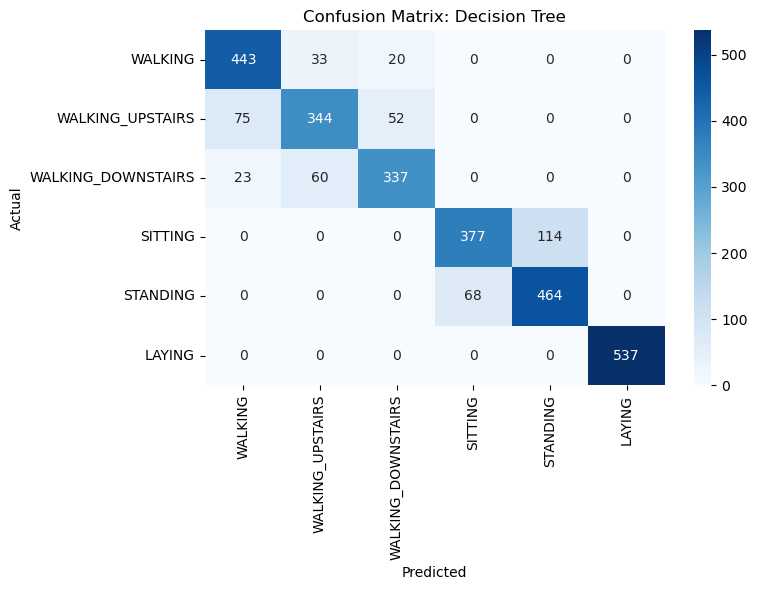

In [55]:
results = {}

for name, model in models.items():
    start = time.time()
    # if name in ["SVM", "MLP", "KNN"]:
    #     model.fit(X_train_scaled, y_train)
    #     y_pred = model.predict(X_test_scaled)
    # else:
    #     model.fit(X_train, y_train)
    #     y_pred = model.predict(X_test)
    # end = time.time()
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_scaled)
    
    end = time.time()

    # Tính các chỉ số (weighted để xử lý imbalance phần nào)
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "f1": f1_score(y_test, y_pred, average='weighted', zero_division=0),
        "time": end - start
    }

    # In báo cáo chi tiết cho mô hình
    print("\n" + "="*40)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred, target_names=activity_labels['label'].values, zero_division=0))

    # Vẽ confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=activity_labels['label'].values,
                yticklabels=activity_labels['label'].values)
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


In [56]:
# Tổng hợp kết quả
df = pd.DataFrame(results).T
print("\n=== Summary (sorted by accuracy) ===")
print(df.sort_values("accuracy", ascending=False))


=== Summary (sorted by accuracy) ===
               accuracy  precision    recall        f1      time
Decision Tree  0.848999   0.849346  0.848999  0.848126  5.543635


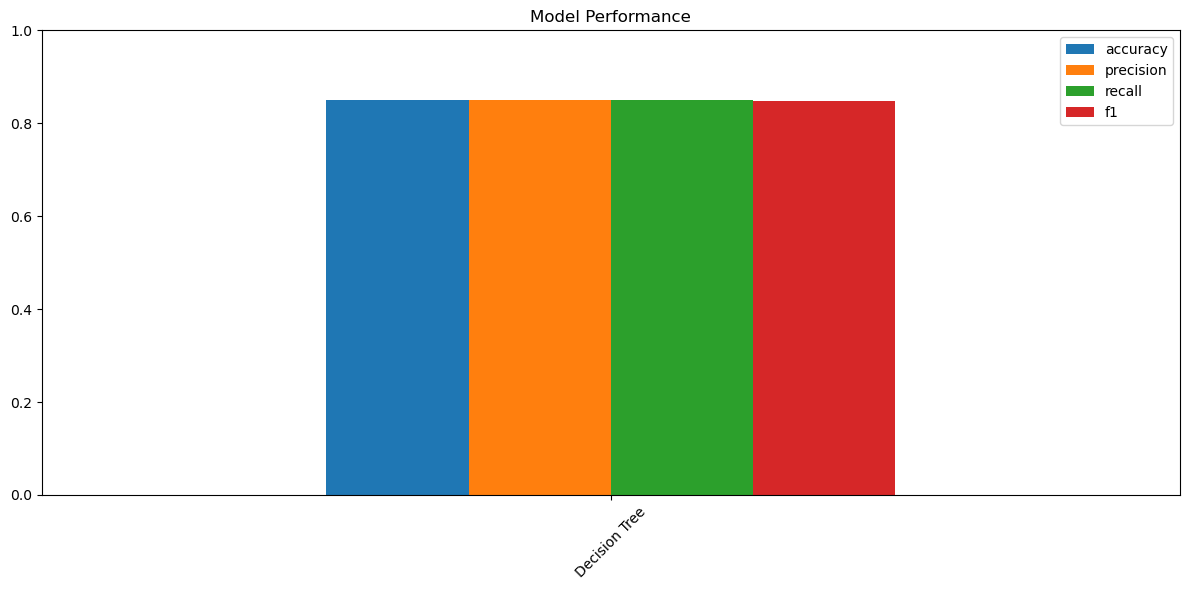

In [57]:
# Vẽ biểu đồ so sánh
metrics_plot = df[['accuracy','precision','recall','f1']].astype(float)
metrics_plot.plot(kind='bar', figsize=(12,6), title="Model Performance")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


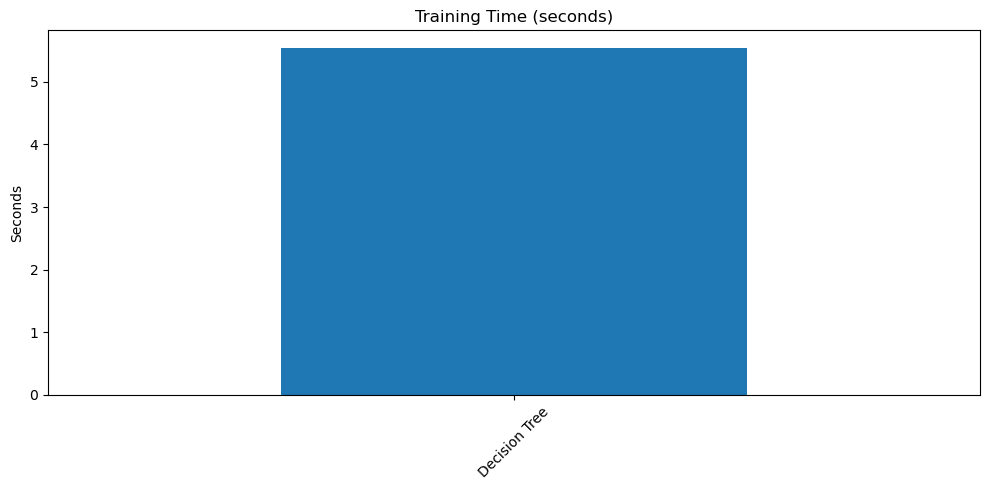

In [58]:
# Thời gian huấn luyện
df['time'].plot(kind='bar', figsize=(10,5), title="Training Time (seconds)")
plt.ylabel("Seconds")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()